# IHLT Lab 6: Word Sense Disambiguation

**Authors:** *Zachary Parent ([zachary.parent](mailto:zachary.parent@estudiantat.upc.edu)), Carlos Jiménez ([carlos.humberto.jimenez](mailto:carlos.humberto.jimenez@estudiantat.upc.edu))*

### 2024-10-24

**Instructions:**

1. Read all pairs of sentences of the SMTeuroparl files of test set within the evaluation framework of the project.

2. Apply WSD algorithms to the words in the sentences.

3. Compute their similarities by considering senses and Jaccard coefficient.

4. Compare the results with those in session 2 (document) and 3 (morphology) in which words and lemmas were considered.

5. Compare the results with gold standard by giving the pearson correlation between them.


## Setup

In [1]:
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from nltk.metrics.distance import jaccard_distance
from functools import partial
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from textserver import TextServer
import config

In [2]:
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("sentiwordnet")
nltk.download("wordnet_ic")

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/zachparent/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/zachparent/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /Users/zachparent/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package wordnet_ic to
[nltk_data]     /Users/zachparent/nltk_data...
[nltk_data]   Package wordnet_ic is already up-to-date!


True

In [3]:
textserver_enabled = False
ts = TextServer(config.TEXT_SERVER_USERNAME, config.TEXT_SERVER_PASSWORD, "morpho")

In [4]:
context = ["I", "went", "to", "the", "bank", "to", "deposit", "money", "."]
synset = nltk.wsd.lesk(context, "bank", "n")

In [5]:
synset.name(), synset.definition()

('savings_bank.n.02',
 'a container (usually with a slot in the top) for keeping money at home')

### 1. Read all pairs of sentences of the SMTeuroparl files of test set within the evaluation framework of the project.

In [6]:
BASE_PATH = "./"

In [7]:
assert BASE_PATH is not None, "BASE_PATH is not set"

## Load the data

In [8]:
dt = pd.read_csv(
    f"{BASE_PATH}/test-gold/STS.input.SMTeuroparl.txt", sep="\t", header=None
)
dt.columns = ["s1", "s2"]
gs = pd.read_csv(f"{BASE_PATH}/test-gold/STS.gs.SMTeuroparl.txt", sep="\t", header=None)
dt["gs"] = gs[0]
dt.head()

,s1,s2,gs
0,The leaders have now been given a new chance a...,The leaders benefit aujourd' hui of a new luck...,4.50
1,Amendment No 7 proposes certain changes in the...,Amendment No 7 is proposing certain changes in...,5.00
2,Let me remind you that our allies include ferv...,I would like to remind you that among our alli...,4.25
3,The vote will take place today at 5.30 p.m.,The vote will take place at 5.30pm,4.50
4,"The fishermen are inactive, tired and disappoi...","The fishermen are inactive, tired and disappoi...",5.00


## Previous results

In [9]:
# Lemmatization methods
wnl = nltk.stem.WordNetLemmatizer()


def lemmatize_one(word):
    x, pos = nltk.pos_tag([word])[0]
    d = {
        "NN": "n",
        "NNS": "n",
        "JJ": "a",
        "JJR": "a",
        "JJS": "a",
        "VB": "v",
        "VBD": "v",
        "VBG": "v",
        "VBN": "v",
        "VBP": "v",
        "VBZ": "v",
        "RB": "r",
        "RBR": "r",
        "RBS": "r",
    }
    if pos in d:
        return wnl.lemmatize(word, pos=d[pos])
    return x


def lemmatize_many(words):
    return [lemmatize_one(word) for word in words]

In [10]:
# Token pre-processing methods
def remove_non_alnum(tokens):
    return [token for token in tokens if token.isalnum()]


def lower(tokens):
    return [token.lower() for token in tokens]


def remove_stopwords(tokens):
    return [
        token for token in tokens if token not in nltk.corpus.stopwords.words("english")
    ]

In [11]:
# Scoring methods
def jaccard_vector(s1, s2):
    return pd.concat([s1, s2], axis=1).apply(
        lambda x: jaccard_distance(set(x.iloc[0]), set(x.iloc[1])), axis=1
    )


def score_jaccard_vector(jaccard_vector, gold_standard=gs):
    return pearsonr(gold_standard[0], jaccard_vector)[0]

In [12]:
results = pd.DataFrame(index=["score"])

s1_tokens = dt["s1"].apply(nltk.word_tokenize).apply(remove_non_alnum).apply(lower)
s2_tokens = dt["s2"].apply(nltk.word_tokenize).apply(remove_non_alnum).apply(lower)
results["tokenize"] = score_jaccard_vector(jaccard_vector(s1_tokens, s2_tokens))

s1_lemmas = (
    dt["s1"]
    .apply(nltk.word_tokenize)
    .apply(remove_non_alnum)
    .apply(lower)
    .apply(remove_stopwords)
    .apply(lemmatize_many)
)
s2_lemmas = (
    dt["s2"]
    .apply(nltk.word_tokenize)
    .apply(remove_non_alnum)
    .apply(lower)
    .apply(remove_stopwords)
    .apply(lemmatize_many)
)
results["lemmatize"] = score_jaccard_vector(jaccard_vector(s1_lemmas, s2_lemmas))

results.head()

,tokenize,lemmatize
score,-0.490289,-0.503693


### 2. Apply WSD algorithms to the words in the sentences.

### Retrieve and cache TextServer response

The TextServer API has a limitation of about 50 requests before it starts failing. I used multiple accounts to get around this, caching the results in a pickle file to save progress. Now, since the cache is filled, we can use it to speed up the process and avoid using the API altogether.

In [13]:
import pickle

CACHE_FILE = "textserver_cache.pkl"


def load_cache():
    try:
        with open(CACHE_FILE, "rb") as f:
            return pickle.load(f)
    except FileNotFoundError:
        return {}


cache = load_cache()


def dump_cache():
    with open(CACHE_FILE, "wb") as f:
        pickle.dump(cache, f)


def get_textserver_response(s):
    if s in cache:
        return cache[s]
    if textserver_enabled:
        try:
            response = ts.senses(s)
            print(f'Successfully got response for "{s}"')
        except Exception as e:
            raise Exception(f'Error getting response for "{s}": {e}')
        cache[s] = response
        return response
    raise Exception(f'TextServer is not enabled and no cache hit for "{s}"')

In [14]:
def get_lesk_synset_if_exists(tokens):
    synsets = [nltk.wsd.lesk(tokens, word) for word in tokens]
    synsets_or_tokens = [
        synset.name() if synset is not None else token
        for synset, token in zip(synsets, tokens)
    ]
    return synsets_or_tokens


def get_ukb_synset_if_exists(tokens):
    try:
        response = get_textserver_response(" ".join(tokens))
    except Exception as e:
        print(e)
        return None
    synset_accessors = [sense[4] for sense in response[0]]
    synsets = [
        (
            wn.synset_from_pos_and_offset(x.split("-")[1], int(x.split("-")[0])).name()
            if x != "N/A"
            else None
        )
        for x in synset_accessors
    ]
    synsets_or_tokens = [
        synset if synset is not None else token
        for synset, token in zip(synsets, tokens)
    ]
    return synsets_or_tokens

In [15]:
s1_with_lesk_synsets = s1_lemmas.apply(get_lesk_synset_if_exists)
s2_with_lesk_synsets = s2_lemmas.apply(get_lesk_synset_if_exists)
results["lesk_synsets"] = score_jaccard_vector(
    jaccard_vector(s1_with_lesk_synsets, s2_with_lesk_synsets)
)

print(f"s1_with_lesk_synsets example: {s1_with_lesk_synsets[0]}")
print(f"s2_with_lesk_synsets example: {s2_with_lesk_synsets[0]}")

s1_with_lesk_synsets example: ['leader.n.01', 'render.v.04', 'newfangled.s.01', 'gamble.v.01', 'permit.v.01', 'uranium.n.01', 'promise.n.02', 'assume.v.06']
s2_with_lesk_synsets example: ['leader.n.01', 'profit.v.01', 'aujourd', 'hui', 'newfangled.s.01', 'luck.n.03', 'permit.v.01', 'permit.v.01', 'therefore.r.01', 'assume.v.06']


In [16]:
s1_with_ukb_synsets = s1_lemmas.apply(get_ukb_synset_if_exists)
s2_with_ukb_synsets = s2_lemmas.apply(get_ukb_synset_if_exists)

good_indices_s1 = s1_with_ukb_synsets.notna()
good_indices_s2 = s2_with_ukb_synsets.notna()
good_indices = good_indices_s1 & good_indices_s2
print(f"Good indices s1: {good_indices_s1.sum()}/{len(good_indices_s1)}")
print(f"Good indices s2: {good_indices_s2.sum()}/{len(good_indices_s2)}")
print(f"Good indices: {good_indices.sum()}/{len(good_indices)}")

s1_with_ukb_synsets = s1_with_ukb_synsets[good_indices]
s2_with_ukb_synsets = s2_with_ukb_synsets[good_indices]

print(f"s1_with_ukb_synsets example: {s1_with_ukb_synsets[0]}")
print(f"s2_with_ukb_synsets example: {s2_with_ukb_synsets[0]}")

Good indices s1: 459/459
Good indices s2: 459/459
Good indices: 459/459
s1_with_ukb_synsets example: ['leader.n.01', 'render.v.04', 'new.a.06', 'opportunity.n.01', 'permit.v.01', 'us', 'hope.v.02', 'seize.v.01']
s2_with_ukb_synsets example: ['leader.n.01', 'benefit.n.02', 'aujourd', 'hui', 'new.a.06', 'luck.n.02', 'permit.v.01', 'permit.v.01', 'therefore.r.01', 'seize.v.01']


As you can see, the number of good indices is equal to the total now, indicating that we have cached all the responses from TextServer.

In [17]:
dump_cache()

### 3. Compute their similarities by considering senses and Jaccard coefficient.

In [18]:
results["ukb_synsets"] = score_jaccard_vector(
    jaccard_vector(s1_with_ukb_synsets, s2_with_ukb_synsets), gs[good_indices]
)
results.head()

,tokenize,lemmatize,lesk_synsets,ukb_synsets
score,-0.490289,-0.503693,-0.500498,-0.492905


### 4. Results comparison

<Figure size 1000x600 with 0 Axes>

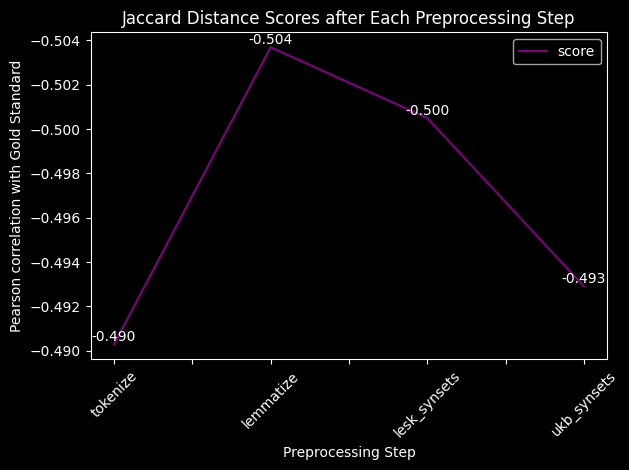

In [19]:
plt.figure(figsize=(10, 6))
results.T.plot(kind="line", color=["purple"])
plt.title("Jaccard Distance Scores after Each Preprocessing Step")
plt.xlabel("Preprocessing Step")
plt.ylabel("Pearson correlation with Gold Standard")
plt.xticks(rotation=45)
plt.gca().invert_yaxis()  # Invert the y-axis
plt.tight_layout()

# Annotate chart values
for i, v in enumerate(results.values[0]):
    plt.text(i, v, f"{v:.3f}", ha="center", va="bottom", color="white")
plt.show()

As we can see above, the pipeline including lemmatization remains the best performing one. Adding sense disambiguation with either Lesk or UKB decreases the performance.

### 5. Leave-one-out analysis

In [20]:
leave_one_out_results = pd.DataFrame(index=["score"])

# Base tokenization (always included)
s1_tokens = dt["s1"].apply(nltk.word_tokenize)
s2_tokens = dt["s2"].apply(nltk.word_tokenize)

# Configuration 1: Skip lowercase
s1_config1 = (
    s1_tokens.apply(remove_non_alnum)
    .apply(remove_stopwords)
    .apply(lemmatize_many)
    .apply(get_lesk_synset_if_exists)
)
s2_config1 = (
    s2_tokens.apply(remove_non_alnum)
    .apply(remove_stopwords)
    .apply(lemmatize_many)
    .apply(get_lesk_synset_if_exists)
)
leave_one_out_results["skip_lowercase"] = score_jaccard_vector(
    jaccard_vector(s1_config1, s2_config1)
)

# Configuration 2: Skip remove non-alnum
s1_config2 = (
    s1_tokens.apply(lower)
    .apply(remove_stopwords)
    .apply(lemmatize_many)
    .apply(get_lesk_synset_if_exists)
)
s2_config2 = (
    s2_tokens.apply(lower)
    .apply(remove_stopwords)
    .apply(lemmatize_many)
    .apply(get_lesk_synset_if_exists)
)
leave_one_out_results["skip_remove_non_alnum"] = score_jaccard_vector(
    jaccard_vector(s1_config2, s2_config2)
)

# Configuration 3: Skip remove stopwords
s1_config3 = (
    s1_tokens.apply(lower)
    .apply(remove_non_alnum)
    .apply(lemmatize_many)
    .apply(get_lesk_synset_if_exists)
)
s2_config3 = (
    s2_tokens.apply(lower)
    .apply(remove_non_alnum)
    .apply(lemmatize_many)
    .apply(get_lesk_synset_if_exists)
)
leave_one_out_results["skip_remove_stopwords"] = score_jaccard_vector(
    jaccard_vector(s1_config3, s2_config3)
)

# Configuration 4: Skip lemmatize
s1_config4 = (
    s1_tokens.apply(lower)
    .apply(remove_non_alnum)
    .apply(remove_stopwords)
    .apply(get_lesk_synset_if_exists)
)
s2_config4 = (
    s2_tokens.apply(lower)
    .apply(remove_non_alnum)
    .apply(remove_stopwords)
    .apply(get_lesk_synset_if_exists)
)
leave_one_out_results["skip_lemmatize"] = score_jaccard_vector(
    jaccard_vector(s1_config4, s2_config4)
)

# Configuration 5: Skip lesk
s1_config5 = (
    s1_tokens.apply(lower)
    .apply(remove_non_alnum)
    .apply(remove_stopwords)
    .apply(lemmatize_many)
)
s2_config5 = (
    s2_tokens.apply(lower)
    .apply(remove_non_alnum)
    .apply(remove_stopwords)
    .apply(lemmatize_many)
)
leave_one_out_results["skip_lesk"] = score_jaccard_vector(
    jaccard_vector(s1_config5, s2_config5)
)

# Add the full pipeline for comparison
s1_full = (
    s1_tokens.apply(lower)
    .apply(remove_non_alnum)
    .apply(remove_stopwords)
    .apply(lemmatize_many)
    .apply(get_lesk_synset_if_exists)
)
s2_full = (
    s2_tokens.apply(lower)
    .apply(remove_non_alnum)
    .apply(remove_stopwords)
    .apply(lemmatize_many)
    .apply(get_lesk_synset_if_exists)
)
leave_one_out_results["full_pipeline"] = score_jaccard_vector(
    jaccard_vector(s1_full, s2_full)
)

print(
    "\033[1mJaccard Distance Correlation with Gold Standard for different configurations:\033[0m"
)
print()
print(leave_one_out_results)

Jaccard Distance Correlation with Gold Standard for different configurations:

       skip_lowercase  skip_remove_non_alnum  skip_remove_stopwords  \
score       -0.477173              -0.466015              -0.431887   

       skip_lemmatize  skip_lesk  full_pipeline  
score       -0.491832  -0.503693      -0.500498  


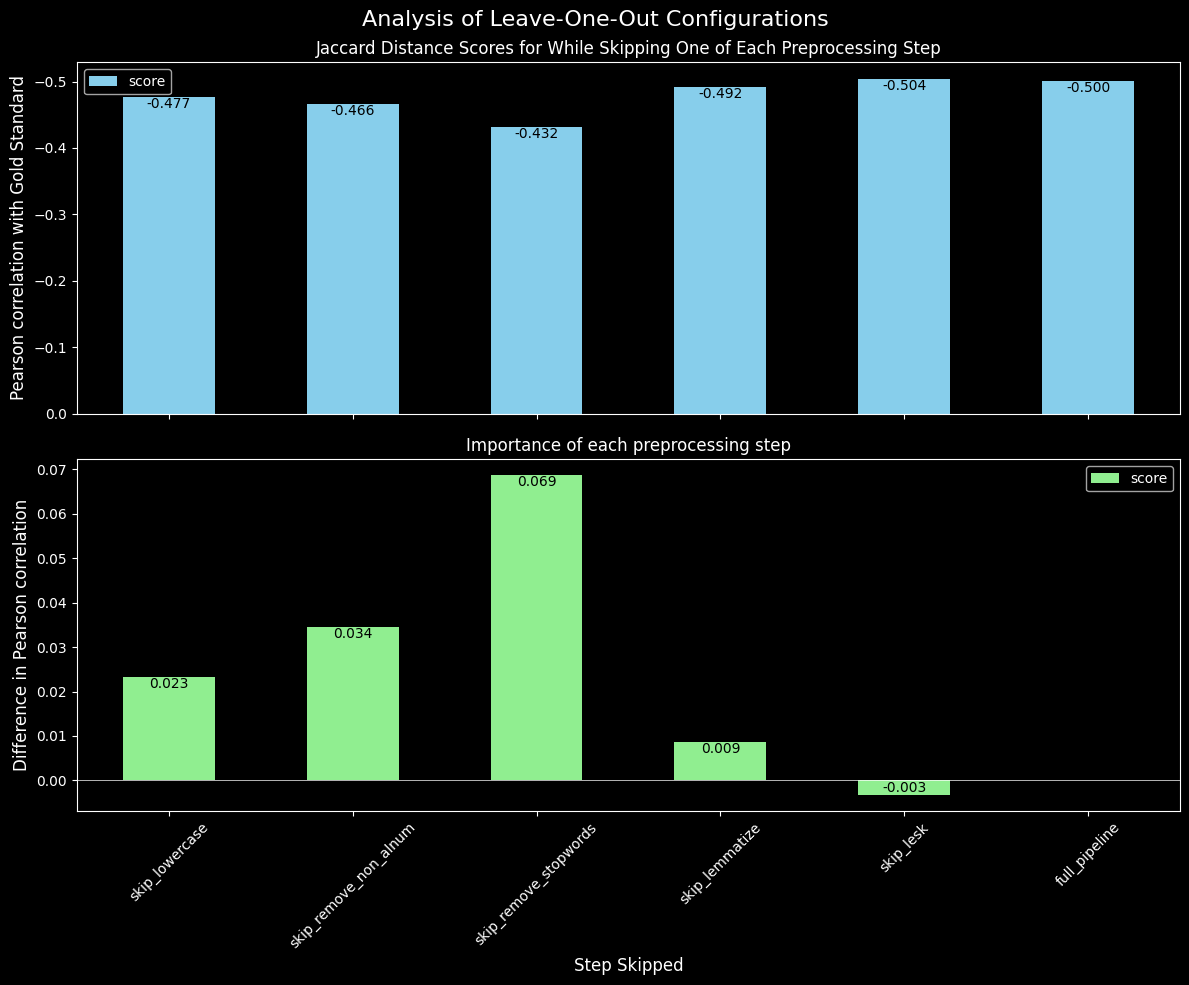

In [21]:
# Plot bar chart for leave-one-out results and differences from full pipeline
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

fig.suptitle("Analysis of Leave-One-Out Configurations", fontsize=16)

# Original bar chart
leave_one_out_results.T.plot(kind="bar", color=["skyblue"], ax=ax1)
ax1.set_title(
    "Jaccard Distance Scores for While Skipping One of Each Preprocessing Step"
)
ax1.set_ylabel("Pearson correlation with Gold Standard", fontsize=12)
ax1.invert_yaxis()


# Annotate original bar chart values
for i, v in enumerate(leave_one_out_results.values[0]):
    ax1.text(i, v, f"{v:.3f}", ha="center", va="top", color="black")

# Calculate and plot differences from full pipeline
full_pipeline_score = leave_one_out_results["full_pipeline"].values[0]
differences = leave_one_out_results.subtract(full_pipeline_score).T
differences.plot(kind="bar", color=["lightgreen"], ax=ax2)
ax2.set_title("Importance of each preprocessing step")
ax2.set_xlabel("Step Skipped", fontsize=12)
ax2.set_ylabel("Difference in Pearson correlation", fontsize=12)
ax2.tick_params(axis="x", rotation=45)

# Annotate difference bar chart values
ax2.axhline(0, color="white", linewidth=0.5)
for i, v in enumerate(differences.values):
    ax2.text(
        i,
        v,
        f"{v[0]:.3f}",
        ha="center",
        va="top" if v[0] > 0 else "bottom",
        color="black",
    )

plt.tight_layout()
plt.show()

Above, we compare the full pipeline, including lemmatization and sense disambiguation via lesk, with the results of skipping each preprocessing step. We can see that skipping stopword removal is the most detrimental, and skipping sense disambiguation is the least detrimental. In fact, skipping lesk improves the results.

# Analysis & Conclusions




### Key Results

In this lab we have continued our work of trying to improve the performance of our similarity analysis between sentences. We have explored the use of word sense disambiguation (WSD) to improve the performance of our metric.

As previously found, simple tokenization yielded a pearson similarity between our jaccard distance scores and the gold standard of `~0.490`. Using lemmatization has also improved the results to `~0.504`. Adding a word sense disambiguation step with Lesk decreased the performance to `~0.500`, and with UKB it was even worse with a score of `~0.493`.

### Lesk vs UKB

We were surprised to find UKB performing worse than Lesk. We hypothesize that this is because UKB is more sensitive to the context of the word, yielding more specific and typically more useful synsets. In contrast, Lesk yields more general synsets, which are more likely to be a good match for the words in the sentences.

### Leave-one-out analysis

We employed the use of leave-one-out analysis to understand the importance of each preprocessing step. We discovered that word sense disambiguation does not improve the performance of our metric, and in fact, skipping it slightly improves the results. This is most likely because the sense disambiguation is sensitive and can lead to very different results in each sentence. In addition, it doesn't help much with softening synonyms, which is something synsets are generally useful for.

Our best performing pipeline is still tokenization, lowercasing, removing non-alphanumeric characters, removing stopwords, and lemmatization, yielding a pearson correlation of `~0.504` with the gold standard.

### Future work

Perhaps in the future we could explore the use of hypernyms from the detected synsets to generalize meaning across synonyms in the 2 sentences.